In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statistics import mean
import pandas as pd
import math 
import scipy.stats as si

In [2]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams['figure.figsize'] = [8, 6]

In [3]:
def BS_call_price_delta(sigma, S, K, r, T, t, Greek):
    
    if Greek == 'Price' and T > 0: # Pris for en call option
        d1 = np.multiply(1. / (sigma*np.sqrt((T-t))),(np.log(S/K) + (r + sigma**2 / 2.) * (T-t)))
        d2 = d1 - sigma * np.sqrt((T-t))
        result = np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2) * K, np.exp(-r * (T-t)))
        
    if Greek == 'Price' and T == 0:
        result = max(S-K,0)
    
    if Greek == "Delta" and T > 0: # dC/dS = Delta - Hvor meget vi skal købe/sælge af det underliggende aktiv
        d1 = np.multiply(1. / (sigma*np.sqrt((T-t))),(np.log(S/K) + (r + sigma**2 / 2.) * (T-t)))
        result = norm.cdf(d1)
        
    
    if Greek == 'Delta' and T == 0:
        result = 0
    
    return result

## Simulering af underliggende aktiv

In [4]:
S0 = 100 #stock price S_{0}
K = 100 # strike
T = 14/52 # time to maturity
t = 0
mu = 0.02 # risk free risk in annual %
sigma = 0.2 # annual volatility in %
steps = 70 # time steps
N = 1 # number of trials ("Antal aktier")

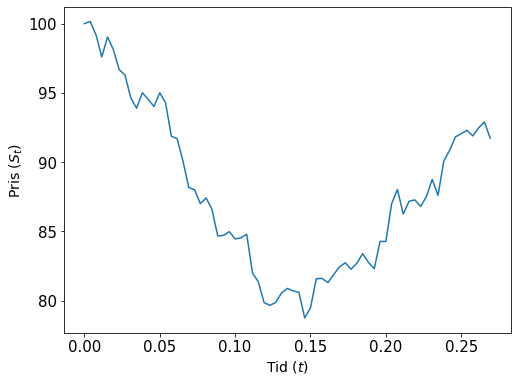

In [5]:
dt = T/steps

St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(N,steps)).T)
St = np.vstack([np.ones(N), St])


St = S0 * St.cumprod(axis=0)

time = np.linspace(0,T,steps+1)


tt = np.full(shape=(N,steps+1), fill_value=time).T

plt.plot(tt, St)
plt.ylabel("Pris $(S_t)$", fontsize=14)
plt.xlabel("Tid $(t)$",fontsize=14);
plt.show()

### Finder pris og delta på underliggende hver uge

In [6]:
liste = []
for i in range(15):
    liste.append(St[5*i][0])

In [7]:
delta_liste = []
for i in range(14):
    delta_liste.append(BS_call_price_delta(0.2,St[5*i][0],100,0.02,(14-i)/52, 0, "Delta"))
delta_liste.append(BS_call_price_delta(0.2,St[5*i][0],100,0.02,(14-13.99)/52, 0, "Delta"))

## Simulering af diskret delta hedge eksperiment

In [8]:
def GBM_sim(S, mu, T, sigma, steps):
    '''
    Vores Geomeriske brownian motion simulering, hvor vi også får et array med tiden
    '''
    dt = T/steps
    W = np.random.standard_normal(size=steps-1)
    W = np.array([0] + list(np.cumsum(W)*np.sqrt(dt)))
    t = np.linspace(0, T, steps)
    S = S*np.exp((mu - 0.5*sigma**2)*t + sigma*W)
    return S,t

In [9]:
def delta(S,K,T,r,q,sigma):
    '''
    Vores delta funktion kan håndtere inputs af arrays 
    '''
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return si.norm.cdf(d1)*np.exp(-q*T)

In [10]:
N = 1 

S0 = 100; K = 100; T = 14/52; r = 0.02; q = 0.0; sigma = 0.2 

steps = 1+70 # 

path = GBM_sim(S0, r-q, T, sigma ,steps)

# Define time interval correctly 
time = np.linspace(0,T,steps)

# Require numpy array that is the same shape as St
tt = np.full(shape=(1,steps), fill_value=time).T
T_T = np.transpose(tt)[0][::-1]
T_T


St = path[0]; 
ttm = 1.0 - path[1]; 
dt = T/steps

d = delta(St, K, T_T, r, q, sigma)

# Initial Position
n_shares = [d[0]*N]
cost_of_shares = [n_shares[0]*S0]

cumulative_cost = [n_shares[0]*S0]

interest_cost = [cumulative_cost[0]*r*dt]

# Rebalancing
for i in range(1, len(d)):
    diff = d[i] - d[i-1]
    n_shares.append(diff*N)
    cost_of_shares.append(n_shares[i]*St[i])
    cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i-1])
    interest_cost.append(cumulative_cost[i]*r*dt)
    
sim = pd.DataFrame({'Stock Price':St, 'Delta':np.round(d, 2),'Shares Purchased':np.array(n_shares)*100,
                    'Cost of Shares':np.array(cost_of_shares)*100,
                    'Cumulative Cost':np.array(cumulative_cost)*100,
                    'Interest Cost':np.array(interest_cost)*100})

<ipython-input-9-890588db5ca2>:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


### Udregning af diverse værdier til samlet P&L

In [11]:
# Værdien af porteføljen i udløbstidspunktet
Værdi_Port = round(sim["Stock Price"][steps-1]*sim["Shares Purchased"].sum(),3)

# Samlet renteomkostninger i udløbstidspunktet
Total_Interest = round(sim["Interest Cost"].sum(),3)

# Modtaget premium i starttidspunktet ved salg af optionerne
Premium = BS_call_price_delta(sigma, St[0], K, r, T_T[0], 0, "Price")*100

# Premium inkl. modtaget rente efter at have den i banken i T periode.
Premium_efterrente = round(Premium*(1+r*T_T[0]),3)

# Den payoff man skal betale til køberen af optionen hvis S_T > K
if sim["Stock Price"][steps-1] > K:
    Betaling_payoff = round((sim["Stock Price"][steps-1] - K)*100,3)
else:
    Betaling_payoff = 0

# Omkostninger ved rebalancering af porteføljen
Total_omk = round(sim["Cost of Shares"].sum(),3)

In [12]:
Profit_samlet = sim["Stock Price"][steps-1]*sim["Shares Purchased"].sum() - sim["Interest Cost"].sum() \
+(BS_call_price_delta(sigma, St[0], K, r, T_T[0], 0, "Price")*100)*(1+r*T_T[0]) \
- Betaling_payoff- sim["Cost of Shares"].sum()

In [13]:
data = [['Samlet Renteomkostninger',-Total_Interest],\
        ['Samlet værdi af porteføljen', Værdi_Port],
        ['Samlet omkostninger ved rebalancering af porteføljen', -Total_omk],
        ['Modtaget premium fra salg af optioner inkl. rente', Premium_efterrente],
        ['Betaling af payoff', -Betaling_payoff]]
data_df = pd.DataFrame(data, columns = ["Omkostning","Pris"])
data_df.loc[len(data_df.index)] = ["Samlet profit",data_df.sum(axis=0)[1]] # Tilføjer samlet profit

## Simulering af dynamisk delta hedging - Rebalancering hver uge

<ipython-input-9-890588db5ca2>:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


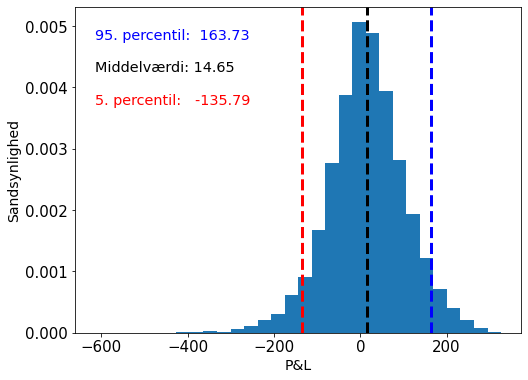

In [14]:
profit_liste = []

N = 1

S0 = 100; K = 100; T = 14/52; r = 0.02; q = 0.0; sigma = 0.2 

steps = 1+14

antal_sim = 10000


for j in range(antal_sim):
    path = GBM_sim(S0, r- q, T, sigma ,steps)

    # Define time interval correctly 
    time = np.linspace(0,T,steps)

    # Require numpy array that is the same shape as St
    tt = np.full(shape=(1,steps), fill_value=time).T
    T_T = np.transpose(tt)[0][::-1]
    T_T


    St = path[0]; 
    ttm = 1.0 - path[1]; 
    dt = T/steps

    d = delta(St, K, T_T, r, q, sigma)

    # Initial Position
    n_shares = [d[0]*N]
    cost_of_shares = [n_shares[0]*S0]

    cumulative_cost = [n_shares[0]*S0]

    interest_cost = [cumulative_cost[0]*r*dt]

    # Rebalancing
    for i in range(1, len(d)):
        diff = d[i] - d[i-1]
        n_shares.append(diff*N)
        cost_of_shares.append(n_shares[i]*St[i])
        cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i-1])
        interest_cost.append(cumulative_cost[i]*r*dt)

    sim = pd.DataFrame({'Stock Price':St, 'Delta':np.round(d, 2),'Shares Purchased':np.array(n_shares)*100,
                        'Cost of Shares':np.array(cost_of_shares)*100,
                        'Cumulative Cost':np.array(cumulative_cost)*100,
                        'Interest Cost':np.array(interest_cost)*100})

    if sim["Stock Price"][steps-1] > K:
        Betaling_payoff = round((sim["Stock Price"][steps-1] - K)*100,3)
    else:
        Betaling_payoff = 0
    
    Profit_samlet = sim["Stock Price"][steps-1]*sim["Shares Purchased"].sum() - sim["Interest Cost"].sum() \
    +(BS_call_price_delta(sigma, St[0], K, r, T_T[0], 0, "Price")*100)*(1+r*T_T[0]) \
    - Betaling_payoff- sim["Cost of Shares"].sum()
    
    profit_liste.append(Profit_samlet)
    
plt.hist(profit_liste,density = True, bins = 30)
plt.ylabel('Sandsynlighed', fontsize=14)
plt.xlabel('P&L',fontsize=14);
mean(profit_liste),np.percentile(profit_liste,5)
plt.axvline(mean(profit_liste), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(profit_liste,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(profit_liste,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(profit_liste,0), max_ylim*0.9, '95. percentil:  {:.2f}'.format(np.percentile(profit_liste,95)), size = "x-large").set_color('blue')
plt.text(np.percentile(profit_liste,0), max_ylim*0.8, 'Middelværdi: {:.2f}'.format(mean(profit_liste)),size = "x-large")
plt.text(np.percentile(profit_liste,0), max_ylim*0.7, '5. percentil:   {:.2f}'.format(np.percentile(profit_liste,5)),size = "x-large").set_color('red')
plt.show()

## Simulering af diskret delta hedging - rebalancering hver dag

<ipython-input-9-890588db5ca2>:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


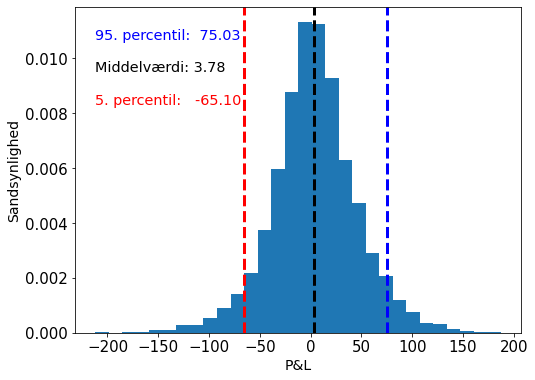

In [15]:
profit_liste = []

N = 1

S0 = 100; K = 100; T = 14/52; r = 0.02; q = 0.0; sigma = 0.2 

steps = 1+70

antal_sim = 10000


for j in range(antal_sim):
    path = GBM_sim(S0, r- q, T, sigma ,steps)

    # Define time interval correctly 
    time = np.linspace(0,T,steps)

    # Require numpy array that is the same shape as St
    tt = np.full(shape=(1,steps), fill_value=time).T
    T_T = np.transpose(tt)[0][::-1]
    T_T


    St = path[0]; 
    ttm = 1.0 - path[1]; 
    dt = T/steps

    d = delta(St, K, T_T, r, q, sigma)

    # Initial Position
    n_shares = [d[0]*N]
    cost_of_shares = [n_shares[0]*S0]

    cumulative_cost = [n_shares[0]*S0]

    interest_cost = [cumulative_cost[0]*r*dt]

    # Rebalancing
    for i in range(1, len(d)):
        diff = d[i] - d[i-1]
        n_shares.append(diff*N)
        cost_of_shares.append(n_shares[i]*St[i])
        cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i-1])
        interest_cost.append(cumulative_cost[i]*r*dt)

    sim = pd.DataFrame({'Stock Price':St, 'Delta':np.round(d, 2),'Shares Purchased':np.array(n_shares)*100,
                        'Cost of Shares':np.array(cost_of_shares)*100,
                        'Cumulative Cost':np.array(cumulative_cost)*100,
                        'Interest Cost':np.array(interest_cost)*100})

    if sim["Stock Price"][steps-1] > K:
        Betaling_payoff = round((sim["Stock Price"][steps-1] - K)*100,3)
    else:
        Betaling_payoff = 0
    
    Profit_samlet = sim["Stock Price"][steps-1]*sim["Shares Purchased"].sum() - sim["Interest Cost"].sum() \
    +(BS_call_price_delta(sigma, St[0], K, r, T_T[0], 0, "Price")*100)*(1+r*T_T[0]) \
    - Betaling_payoff- sim["Cost of Shares"].sum()
    
    profit_liste.append(Profit_samlet)
plt.hist(profit_liste,density = True, bins = 30)
plt.ylabel('Sandsynlighed', fontsize=14)
plt.xlabel('P&L',fontsize=14);
mean(profit_liste),np.percentile(profit_liste,5)
plt.axvline(mean(profit_liste), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(profit_liste,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(profit_liste,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(profit_liste,0), max_ylim*0.9, '95. percentil:  {:.2f}'.format(np.percentile(profit_liste,95)), size = "x-large").set_color('blue')
plt.text(np.percentile(profit_liste,0), max_ylim*0.8, 'Middelværdi: {:.2f}'.format(mean(profit_liste)),size = "x-large")
plt.text(np.percentile(profit_liste,0), max_ylim*0.7, '5. percentil:   {:.2f}'.format(np.percentile(profit_liste,5)),size = "x-large").set_color('red')
plt.show()

## Simulering af diskret delta hedging - rebalancering hver time

<ipython-input-9-890588db5ca2>:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


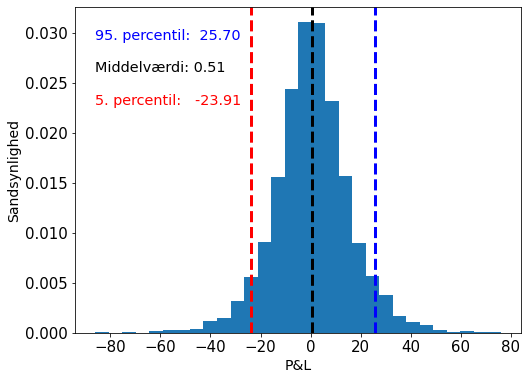

In [16]:
profit_liste = []

N = 1

S0 = 100; K = 100; T = 14/52; r = 0.02; q = 0.0; sigma = 0.2 

steps = 1+70*8

antal_sim = 10000


for j in range(antal_sim):
    path = GBM_sim(S0, r- q, T, sigma ,steps)

    # Define time interval correctly 
    time = np.linspace(0,T,steps)

    # Require numpy array that is the same shape as St
    tt = np.full(shape=(1,steps), fill_value=time).T
    T_T = np.transpose(tt)[0][::-1]
    T_T


    St = path[0]; 
    ttm = 1.0 - path[1]; 
    dt = T/steps

    d = delta(St, K, T_T, r, q, sigma)

    # Initial Position
    n_shares = [d[0]*N]
    cost_of_shares = [n_shares[0]*S0]

    cumulative_cost = [n_shares[0]*S0]

    interest_cost = [cumulative_cost[0]*r*dt]

    # Rebalancing
    for i in range(1, len(d)):
        diff = d[i] - d[i-1]
        n_shares.append(diff*N)
        cost_of_shares.append(n_shares[i]*St[i])
        cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i-1])
        interest_cost.append(cumulative_cost[i]*r*dt)

    sim = pd.DataFrame({'Stock Price':St, 'Delta':np.round(d, 2),'Shares Purchased':np.array(n_shares)*100,
                        'Cost of Shares':np.array(cost_of_shares)*100,
                        'Cumulative Cost':np.array(cumulative_cost)*100,
                        'Interest Cost':np.array(interest_cost)*100})

    if sim["Stock Price"][steps-1] > K:
        Betaling_payoff = round((sim["Stock Price"][steps-1] - K)*100,3)
    else:
        Betaling_payoff = 0
    
    Profit_samlet = sim["Stock Price"][steps-1]*sim["Shares Purchased"].sum() -\
    sim["Interest Cost"].sum() +(BS_call_price_delta(sigma, St[0], K, r, T_T[0], 0, "Price")*100)*(1+r*T_T[0]) \
    - Betaling_payoff- sim["Cost of Shares"].sum()
    profit_liste.append(Profit_samlet)
plt.hist(profit_liste,density = True, bins = 30)
plt.ylabel('Sandsynlighed', fontsize=14)
plt.xlabel('P&L',fontsize=14);
mean(profit_liste),np.percentile(profit_liste,5)
plt.axvline(mean(profit_liste), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(profit_liste,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(profit_liste,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(profit_liste,0), max_ylim*0.9, '95. percentil:  {:.2f}'.format(np.percentile(profit_liste,95)), size = "x-large").set_color('blue')
plt.text(np.percentile(profit_liste,0), max_ylim*0.8, 'Middelværdi: {:.2f}'.format(mean(profit_liste)),size = "x-large")
plt.text(np.percentile(profit_liste,0), max_ylim*0.7, '5. percentil:   {:.2f}'.format(np.percentile(profit_liste,5)),size = "x-large").set_color('red')
plt.show()